In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Deep_learning'

/content/drive/MyDrive/Deep_learning


In [4]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
!pip install torchinfo
from torchinfo import summary

from pytorchcv import train, plot_results, train_long, display_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size = 3, padding = 1)
    )

In [6]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim = 1)
        return X

In [8]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size = 1),
        nn.AvgPool2d(kernel_size = 2, stride = 2)
    )

In [16]:
class DenseNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size = 7, stride = 2, padding = 3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

    def __init__(self, num_channels = 64, growth_rate = 32, arch = (4, 4, 4, 4), lr = 0.1, num_classes = 10):
        super(DenseNet, self).__init__()
        self.num_channels = num_channels
        self.growth_rate = growth_rate
        self.lr = lr
        self.num_classes = num_classes
        self.net = nn.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs, growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs*growth_rate
            # A transition layer that halves the number of channels is added between the dense blocks
            if i != len(arch) - 1:
                num_channels //=2
                self.net.add_module(f'tran_blk{i+1}', transition_block(num_channels))
        
        self.net.add_module('last', nn.Sequential(
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
            nn.LazyLinear(num_classes)
        ))

    def forward(self, X):
        return self.net(X)

    def layer_summary(self, input_size, device = 'cpu'):
        X = torch.randn(*input_size).to(device)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)
    
    def apply_init(self, inputs, init = None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)
    
def init_cnn(module):
    """Initialize weights for CNNs"""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [10]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(96), transforms.ToTensor(), std_normalize])

data_train = datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = trans
)

data_val = datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = trans
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


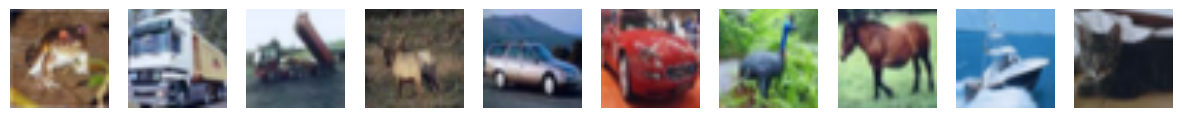

In [11]:
display_dataset(data_train)

In [13]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 128, pin_memory = True)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
net = DenseNet()
net.apply_init([next(iter(train_loader))[0]], init_cnn)

In [19]:
net.layer_summary(input_size = [1,3,96,96])

Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


In [20]:
summary(net, input_size = [1,3,96,96])

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [1, 10]                   --
├─Sequential: 1-1                             [1, 10]                   --
│    └─Sequential: 2-1                        [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-1                       [1, 64, 48, 48]           9,472
│    │    └─BatchNorm2d: 3-2                  [1, 64, 48, 48]           128
│    │    └─ReLU: 3-3                         [1, 64, 48, 48]           --
│    │    └─MaxPool2d: 3-4                    [1, 64, 24, 24]           --
│    └─DenseBlock: 2-2                        [1, 192, 24, 24]          --
│    │    └─Sequential: 3-5                   --                        130,048
│    └─Sequential: 2-3                        [1, 96, 12, 12]           --
│    │    └─BatchNorm2d: 3-6                  [1, 192, 24, 24]          384
│    │    └─ReLU: 3-7                         [1, 192, 24, 24]          --
│    │    

In [21]:
print(net)

DenseNet(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (dense_blk1): DenseBlock(
      (net): Sequential(
        (0): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
          (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (2): Sequential(
          (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
       

In [22]:
optimizer = torch.optim.SGD(net.parameters(), lr = net.lr, momentum = 0.9, nesterov = True)
hist = train(net, train_loader, val_loader, optimizer = optimizer, epochs = 5, loss_fn = nn.CrossEntropyLoss())

Epoch  0, Train acc=0.511, Val acc=0.597, Train loss=0.011, Val loss=0.009
Epoch  1, Train acc=0.680, Val acc=0.703, Train loss=0.007, Val loss=0.007
Epoch  2, Train acc=0.748, Val acc=0.728, Train loss=0.006, Val loss=0.006
Epoch  3, Train acc=0.794, Val acc=0.766, Train loss=0.005, Val loss=0.005
Epoch  4, Train acc=0.825, Val acc=0.791, Train loss=0.004, Val loss=0.005


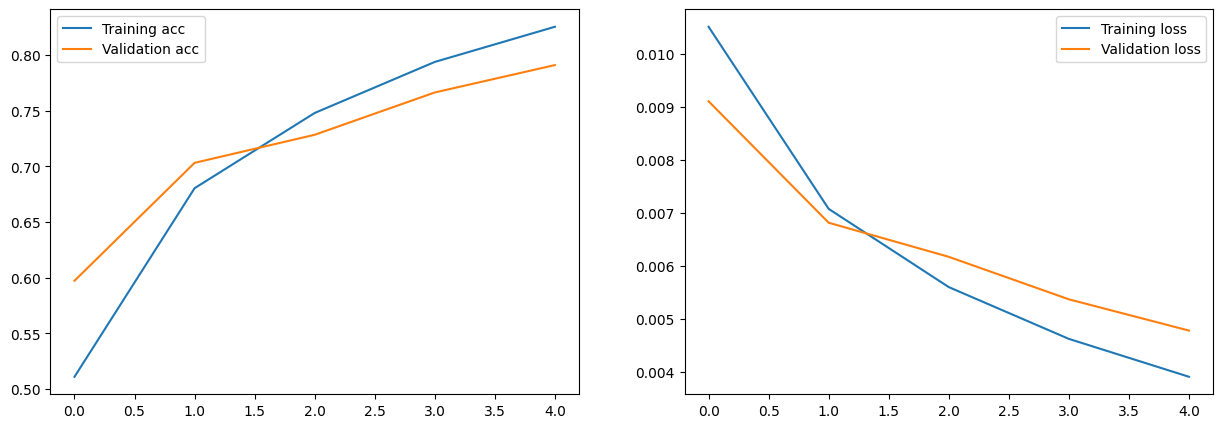

In [23]:
plot_results(hist)

In [24]:
#!wget https://raw.githubusercontent.com/xbresson/CE7454_2019/master/codes/labs_lecture06/lab01_mnist_multilayer/utils.py

In [25]:
import utils

Text(0.5, 1.0, 'label: 3')

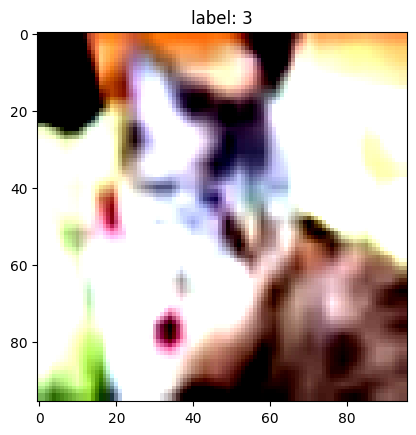

In [26]:
import numpy as np
import matplotlib.pyplot as plt
img, label = data_val[np.random.randint(8,21)]
plt.imshow(img.permute(1,2,0))
plt.title(f'label: {label}')

In [27]:
prob = net(img.unsqueeze(0).to('cuda'))
softmax = nn.Softmax()
prob = softmax(prob)
print(prob)

tensor([[3.2280e-04, 7.3825e-06, 2.4136e-03, 8.2982e-01, 2.8132e-02, 1.1061e-01,
         7.3191e-04, 2.7907e-02, 1.1830e-05, 4.5105e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


<ipython-input-27-7fb306ad7e93>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = softmax(prob)


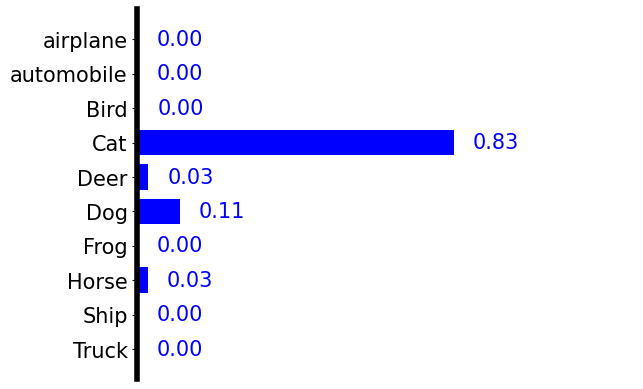

In [28]:
utils.show_prob_cifar(prob.to('cpu'))